<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# 2 Experimenting with RNN

## 2.0 Import libraries

1. [Comet ML](https://www.comet.com/) - is an experiment and model tracking API which allows easy logging of model hyperparameters and experiment metrics.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import spacy
import comet_ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data/imdb)
data_dir = os.path.join(path, 'data', 'imdb')

# Set the directory to the shared dataset folder (should be in shared/datasets/imdb)
dataset_dir = os.path.join(path, '..', 'shared', 'datasets', 'imdb')

# Set the directory to the shared models folder (should be in shared/models/imdb)
model_dir = os.path.join(path, '..', 'shared', 'models', 'imdb')

# Load the Spacy language model ('en_core_web_md' should be in shared/models/spacy)
nlp = spacy.load(os.path.join(path, '..', 'shared', 'models', 'spacy'))

## 2.1 Load and pre-process data

In [2]:
# Load the imdb dataset
imdb_data = pd.read_csv(os.path.join(dataset_dir, 'imdb_dataset.csv'))

# Load your imdb reviews
imdb_reviews = pd.read_csv(os.path.join(data_dir, 'imdb_reviews.csv'))

# Convert the sentiment to a binary value
imdb_data['sentiment'] = pd.get_dummies(imdb_data['sentiment'], drop_first=True)
imdb_reviews['sentiment'] = pd.get_dummies(imdb_reviews['sentiment'], drop_first=True)

imdb_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter mattei s love in the time of money is a...,1


### Load the vocabulary

In [3]:
# Load the vocabulary file and store each word in a list
with open(os.path.join(dataset_dir, 'imdb_vocab.txt'), 'r') as file:
    imdb_vocab = file.read().splitlines() 

# Set the vocab size
vocab_size = 2000
imdb_vocab = imdb_vocab[:vocab_size]

# Print the vocabulary
print(f"Vocabulary size: {len(imdb_vocab)}")
for i, word in enumerate(imdb_vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')

Vocabulary size: 2000
(0, the) (1, and) (2, a) (3, of) (4, is) (5, to) (6, it) (7, in) (8, i) (9, this) (10, that) (11, not) (12, was) (13, as) (14, movie) (15, for) (16, with) (17, but) (18, film) (19, you) (20, on) (21, are) (22, have) (23, s) (24, he) (25, his) (26, one) (27, be) (28, all) (29, at) (30, they) (31, by) (32, an) (33, who) (34, so) (35, from) (36, like) (37, there) (38, or) (39, do) (40, just) (41, her) (42, out) (43, about) (44, if) (45, has) (46, what) (47, can) (48, would) (49, some) 

### Process the text

In [4]:
# Set the maximum sequence length
max_seq_len = 200

# Get the reviews
X = imdb_data['review'].values
print(f'Shape of X: {X.shape}')
print(X[:5])

# Get the class labels
y = imdb_data['sentiment'].values
print(f'Shape of y: {y.shape}')
print(y[:5])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the test data
X_test = imdb_reviews['review'].values
y_test = imdb_reviews['sentiment'].values

Shape of X: (50000,)
['one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows w

### Create an embedding matrix

In [5]:
# Set the embedding dimension
embedding_dim = 50

# Load the word embeddings
w2v_model = Word2Vec.load(os.path.join(model_dir, 'imdb_w2v.model'))

# Generate the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(imdb_vocab):
    if word in w2v_model.wv.key_to_index:
        embedding_matrix[i] = w2v_model.wv.get_vector(word)[:embedding_dim]

# Show the embedding matrix
print(f"Shape of embeddings: {embedding_matrix.shape}")
print(embedding_matrix)

Shape of embeddings: (2000, 50)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.00894076 -0.12877092 -0.04895075 ...  0.14032619  0.10201658
   0.34646019]
 [ 0.17975898  0.03691994 -0.0170421  ...  0.11182626 -0.01342651
   0.08303089]
 [ 0.20864272 -0.06361175 -0.23851547 ...  0.11337754  0.2491575
   0.01783207]]


In [6]:
def build_model(input_data, max_seq_len, embed_matrix, units=32, bi_dir=False, stacked=False, n_class=1, optimiser='adam', lr=0.001):
    """Builds a LSTM model with the given parameters.
    
    Arguments:
        input_data (np.array): The training set inputs
        max_seq_len (int): The maximum sequence length
        embed_matrix (np.array): An embedding matrix
        units (int): The number of LSTM units
        bi_dir (bool): Whether to use a bidirectional LSTM
        stacked (bool): Whether to use a stacked LSTM
        n_class (int): The number of classes to predict
        optimiser (str): The optimiser to use
        lr (str): The optimiser learning rate to use
    """
    # Add your code from exercise 1.3 here
    # Input layer
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

    # Vectorization layer
    vectorize_layer = layers.TextVectorization(
        standardize=None,
        split='whitespace',
        output_mode='int',
        output_sequence_length=max_seq_len,
        max_tokens=embed_matrix.shape[0] - 2  # OOV tokens
    )
    vectorize_layer.adapt(input_data)
    vectorized = vectorize_layer(inputs)

    # Embedding layer
    embedding_layer = layers.Embedding(
        input_dim=embed_matrix.shape[0],
        output_dim=embed_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embed_matrix),
        mask_zero=True
    )
    embedded = embedding_layer(vectorized)

    # LSTM layers
    x = embedded
    if stacked:
        # First LSTM layer returns sequences for the next layer
        if bi_dir:
            lstm = layers.Bidirectional(layers.LSTM(units, return_sequences=True))
        else:
            lstm = layers.LSTM(units, return_sequences=True)
        x = lstm(x)

        # Second LSTM layer returns only the last output
        if bi_dir:
            lstm = layers.Bidirectional(layers.LSTM(units, return_sequences=False))
        else:
            lstm = layers.LSTM(units, return_sequences=False)
        x = lstm(x)
    else:
        # Single LSTM layer
        if bi_dir:
            lstm = layers.Bidirectional(layers.LSTM(units, return_sequences=False))
        else:
            lstm = layers.LSTM(units, return_sequences=False)
        x = lstm(x)

    # Output layer
    outputs = layers.Dense(n_class, activation='sigmoid')(x)

    # Create and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.get(optimiser)
    opt.learning_rate = lr
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

<div class="alert alert-info" style="color:black"><h2>2.2 Exercise: Experiment with Comet ML</h2>

Now we will experiment with some different LSTM model architectures and hyperparameters but we will use [Comet ML](https://www.comet.com/site/) to log the training metrics and model hyperparameters. This will allow us to compare the impact of different models and different hyperparamters on the sentiment classification task. Comet allows you to track models, experiments and also produce graphs for comparison.

Working in small groups of 2 to 4 to complete the following:

1. You will need a Comet ML account and ideally to have created a project. Once you have an account you will need your API key. A guide can be found [here](https://www.comet.com/docs/v2/guides/getting-started/quickstart/). You should be able to provide access to a Comet project for all members of the group, so that everyone can log experiments.

2. The first two lines below create a comet experiment object that will be used to track the training and log metrics/parameters. You need the API key and to provide a project name. Then we can also provide a name for this experiment.

3. Next some experiment and model hyperparameters are set within a dictionary. These can be any relevant values but for now we have one pre-processing parameter (`max_seq_len`), several model hyperparameters and some training parameters (`batch_size` and `epochs`).

4. Build the model using the function you created in 1.3 (you can extend it if you wish), except use the parameters defined within the dictionary.

5. Then, try experimenting with a few different architectures and hyperparameters to evaluate the impact on classification accuracy. Individually you could each explore the impact of different experiment parameters and then use Comet to compare results e.g. one person explores sequence lengths, another model hyperparameters, optimisers and learning rates and so on.

6. Once you have a decent number of experiments/results (10 to 20 is fine) create a short report in Comet ML to present your findings. You can find a template to get you started [here](https://www.comet.com/nathanduran/imdb-sentiment-analysis/reports/hyperparameter-search). Make sure it includes some informative graphs/visualisations!

</div>

In [7]:
# Authenticate the user with the Comet.ml API using login
# then Comet will asked you to input API key
comet_ml.login()

In [10]:
if not grading:
    # Create the comet ml experiment
    experiment = comet_ml.Experiment(project_name="imdb-sentiment-analysis", log_env_gpu=False)
    experiment.set_name('lstm')
    
    # Set and log the hyperparameters
    params = {'max_seq_len': 200,
              'lstm_units': 32,
              'bi_dir': False,
              'stacked': False,
              'optimizer': 'rmsprop',
              'learning_rate': 0.001,
              'batch_size': 128,
              'epochs': 5}
    
    experiment.log_parameters(params)
    
    # Build the model
    model = build_model(X_train,
                        params['max_seq_len'],
                        embedding_matrix,
                        units=params['lstm_units'],
                        bi_dir=params['bi_dir'],
                        stacked=params['stacked'],
                        n_class=1,
                        optimiser=params['optimizer'],
                        lr=params['learning_rate'])
    model.summary()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, keras.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/reicraftscodes/imdb-sentiment-analysis/d170a177fbd744c5a19d9ded72688e9f

COMET INFO: Couldn't find a Git repository in '/home/jovyan/ML-LV/Week4' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 200)       │          0 │ input_layer[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 50)   │    100,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │     10,624 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         33 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,657 (432.25 KB)

 Trainable params: 110,657 (432.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train and evaluate the model

Train the model as before, but use `model.evaluate()` to get a test set accuracy and log that with Comet. We will also log the confusion matrix so that it can be viewed in the experiment on Comet.

Once training and evaluation is complete the experiment should be visible on Comet ML. You can create graphs (Panels) to display results across multiple experiments. You can also view the results of each individual experiment.

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.5853 - loss: 0.6575 - val_accuracy: 0.7965 - val_loss: 0.4587
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.7933 - loss: 0.4612 - val_accuracy: 0.7738 - val_loss: 0.4736
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8271 - loss: 0.3985 - val_accuracy: 0.8506 - val_loss: 0.3515
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.8481 - loss: 0.3604 - val_accuracy: 0.8627 - val_loss: 0.3188
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.8631 - loss: 0.3271 - val_accuracy: 0.8472 - val_loss: 0.3548
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Validation Accuracy: 0.8472


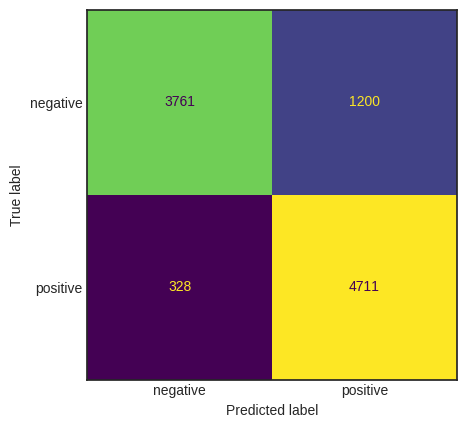

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6199 - loss: 0.7854
Test Accuracy: 0.6200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


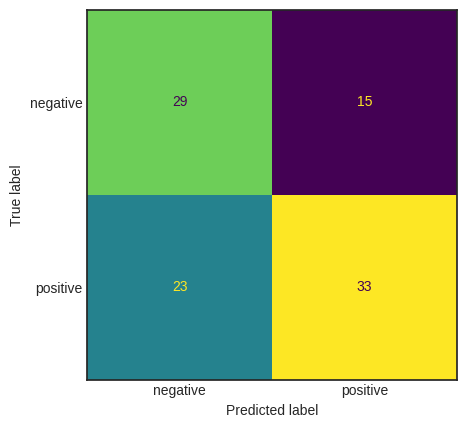

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : lstm
COMET INFO:     url                   : https://www.comet.com/reicraftscodes/imdb-sentiment-analysis/d170a177fbd744c5a19d9ded72688e9f
COMET INFO:   Metrics:
COMET INFO:     test_accuracy : 0.6200000047683716
COMET INFO:   Others:
COMET INFO:     Name : lstm
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 128
COMET INFO:     bi_dir        : False
COMET INFO:     epochs        : 5
COMET INFO:     learning_rate : 0.001
COMET INFO:     lstm_units    : 32
COMET INFO:     max_seq_len   : 200
COMET INFO:     optimizer     : rmsprop
COMET INFO:     stacked       : False
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
CO

In [11]:
if not grading:
    # Fit the model
    results = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_val, y_val))
    
    # Predict class labels for validation set
    predictions = model.predict(X_val)
    predictions = [0 if x < 0.5 else 1 for x in predictions]  # Convert probabilities to binary
    print(f'Validation Accuracy: {accuracy_score(y_val, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_acc:.4f}')
    experiment.log_metric("test_accuracy", test_acc)
    
    # Predict class labels for test set
    predictions = model.predict(X_test)
    predictions = [0 if x < 0.5 else 1 for x in predictions] # Convert probabilities to binary
    
    # Print/log confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()
    experiment.log_confusion_matrix(y_test, predictions, labels=['negative', 'positive'])
    
    # End the experiment
    experiment.end()

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280